# Objective: Match PyMorph with RedMapper, and compare stellar masses

In [7]:
import os

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['dtype']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [9]:
from astropy.io.ascii import read
from astropy.coordinates import SkyCoord
from astropy import units as u
import fitsio
import seaborn as sns

In [2]:
def medxbin(x,y,binsize,minpts=20,xmin=None,xmax=None):
    """
    Compute the median (and other statistics) in fixed bins along the x-axis.
    """
    import numpy as np
    from scipy import ptp

    # Need an exception if there are fewer than three arguments.

    if xmin==None:
        xmin = x.min()
    if xmax==None:
        xmax = x.max()
    #print(xmin,xmax)

    nbin = int(ptp(x)/binsize)
    bins = np.linspace(xmin,xmax,nbin)
    idx  = np.digitize(x,bins)
    #print(nbin, bins, xmin, xmax)

    stats = np.zeros(nbin,[('median','f8'),('sigma','f8'),('iqr','f8')])
    for kk in np.arange(nbin):
        npts = len(y[idx==kk])
        if npts>minpts:
            stats['median'][kk] = np.median(y[idx==kk])
            stats['sigma'][kk] = np.std(y[idx==kk])
            stats['iqr'][kk] = np.subtract(*np.percentile(y[idx==kk],[75, 25]))

    # Remove bins with too few points.
    good = np.nonzero(stats['median'])
    stats = stats[good]

    return bins[good], stats

In [10]:
# Setting convenient paths
pypath = os.path.join(os.sep, 'global', 'work', 'projects', 'legacysurvey', 'legacycentrals')
meertcat = os.path.join(pypath, 'meert_et_al_data_tables_v2')
mendelcat = os.path.join(pypath, 'UPenn_PhotDec_Mstar_mlMendel14.dat')
wisccat = os.path.join(pypath, 'UPenn_PhotDec_Mstar_mlPCAWiscM11.dat')
rmpath = os.path.join(os.sep, 'global', 'work', 'projects', 'redmapper')
rmcatfile = os.path.join(rmpath, 'redmapper_isedfit_v5.10_centrals.fits.gz')

In [11]:
# Reas in RedMaPPer data
rminfo = fitsio.FITS(rmcatfile)
rmcat = rminfo[1].read(columns=['Z', 'RA', 'DEC', 'LAMBDA_CHISQ', 'MSTAR_50', 'MSTAR_ERR', 'IMAG'])

In [12]:
# Read the Mendel catalog
# Tab3 includes the effects of dust, while Tab5 does not.
columns = ('GalCount', 'FlagSerExp', 'Mstar_Tab5_Pymorph',
           'Mstar_Tab5_Truncated', 'Mstar_Tab3_Pymorph',
           'Mstar_Tab3_Truncated', 'Mstar_Tab5_Mendel',
           'Mstar_Tab3_Mendel', 'Mstar_Tab5_cModel',
           'Mstar_Tab3_cModel')
dtype = np.dtype([(col, np.float) for col in columns])
allmendel = np.loadtxt(mendelcat, dtype=dtype)

In [13]:
# Keep good measurements and data.
keep = (np.where(allmendel['FlagSerExp'] == 0) and np.where(allmendel['Mstar_Tab5_Pymorph'] > 0))[0]
print('Keeping {} / {} measurements in the Mendel catalog.'.format(len(keep), len(allmendel)))
mendel = allmendel[keep]

Keeping 654801 / 670722 measurements in the Mendel catalog.


In [14]:
# Read the parent Meert catalog to get ra, dec and other info.
upenncatfile = os.path.join(meertcat, 'UPenn_PhotDec_CAST.fits')
upenncat = fitsio.read(upenncatfile, ext=1, rows=keep, upper=True)

In [15]:
# Cross-matching RedMaPPer and PyMorph
rcoord = SkyCoord(ra=rmcat['RA']*u.degree, dec=rmcat['DEC']*u.degree)
upenn = SkyCoord(ra=upenncat['RA']*u.degree, dec=upenncat['DEC']*u.degree)
idx, sep2d, dist3d = rcoord.match_to_catalog_sky(upenn, nthneighbor=1)

In [18]:
# Applying a limiting tolerance to matches
gd = np.where(sep2d < 3 * u.arcsec)[0]
print(len(gd))

23599


### Inspecting the catalogs.

/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


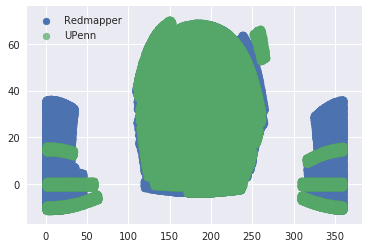

In [19]:
fig, ax = plt.subplots()
ax.scatter(rmcat['RA'], rmcat['DEC'], label='Redmapper')
ax.scatter(upenncat['RA'], upenncat['DEC'], alpha=0.7, label='UPenn')
ax.legend(loc='upper left')

/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


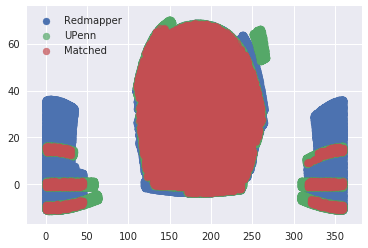

In [20]:
fig, ax = plt.subplots()
ax.scatter(rmcat['RA'], rmcat['DEC'], label='Redmapper')
ax.scatter(upenncat['RA'], upenncat['DEC'], alpha=0.7, label='UPenn')
ax.scatter(upenncat['RA'][idx[gd]], upenncat['DEC'][idx[gd]], alpha=0.7, label='Matched')
ax.legend(loc='upper left')

/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


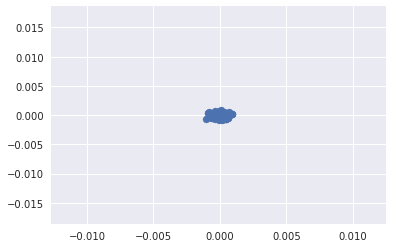

In [21]:
plt.scatter(rmcat['RA'][gd] - upenncat['RA'][idx[gd]], rmcat['DEC'][gd] - upenncat['DEC'][idx[gd]])

In [22]:
(rmcat['RA'] - upenncat[idx]['RA']) * 3600

array([   1.21145462,   88.37902542,  -46.95989881, ..., -295.143147  ,
        -84.02245114, -111.28514995])

/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


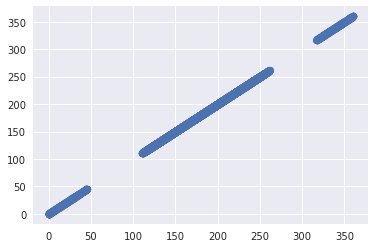

In [23]:
fig, ax = plt.subplots()
plt.scatter(rmcat['RA'][gd], upenncat['RA'][idx[gd]])

/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


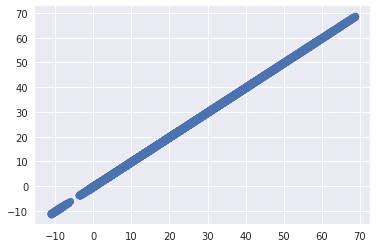

In [24]:
fig, ax = plt.subplots()
plt.scatter(rmcat['DEC'][gd], upenncat['DEC'][idx[gd]])

### PyMorph/Mendel vs. RedMaPPer Stellar Masses

AttributeError: 'AxesSubplot' object has no attribute 'xlabel'

/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


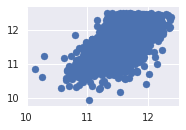

In [25]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.scatter(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab5_Pymorph'][idx[gd]])
ax1.xlabel('RedMaPPer')
ax1.ylabel('PyMorph_5')

ax2 = fig.add_subplot(222)
ax2.scatter(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab3_Pymorph'][idx[gd]])
ax2.xlabel('RedMaPPer')
ax2.ylabel('PyMorph_3')

ax3 = fig.add_subplot(223)
ax3.scatter(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab5_Mendel'][idx[gd]])
ax3.xlabel('RedMaPPer')
ax3.ylabel('Mendel_5')

ax4 = fig.add_subplot(224)
ax4.scatter(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab3_Mendel'][idx[gd]])
ax4.xlabel('RedMaPPer')
ax4.ylabel('Mendel_3')

In [ ]:
_ = plt.hist(rmcat['Z'], bins=100, label='full')
_ = plt.hist(rmcat['Z'][gd], bins=100, label='matched')
plt.legend()

In [ ]:
_ = plt.hist(rmcat['LAMBDA_CHISQ'], bins=100, label='full')
_ = plt.hist(rmcat['LAMBDA_CHISQ'][gd], bins=100, label='matched')
plt.legend()

In [ ]:
_ = plt.hist(rmcat['IMAG'], bins=100, label='full')
_ = plt.hist(rmcat['IMAG'][gd], bins=100, label='matched')
plt.legend()

In [ ]:
sns.kdeplot(rmcat['Z'][gd], rmcat['LAMBDA_CHISQ'][gd],
            cmap="Blues", shade=True, shade_lowest=False)
plt.xlim(0,0.3)
plt.ylim(0,25)

# Residuals

In [ ]:
blah = medxbin(rmcat['MSTAR_50'][gd]-mendel['Mstar_Tab5_Mendel'][idx[gd]], mendel['Mstar_Tab5_Mendel'][idx[gd]],0.1)

In [ ]:
blah

In [ ]:
sns.kdeplot(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab5_Pymorph'][idx[gd]],
            cmap="Blues", shade=True, shade_lowest=False)